# Spin glass optimization


Preamble: Run the cells below to import the necessary Python packages

<!-- *This notebook created by William Gilpin. Consult the [course website](https://www.wgilpin.com/cphy) for all content and [GitHub repository](https://github.com/williamgilpin/cphy) for raw files and runnable online code.* -->

Open this notebook in Google Colab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/spin_glass.ipynb)

In [7]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline



# Spin glasses and the Sherrington-Kirkpatrick model

The Sherrington-Kirkpatrick (SK) model is a model of a spin glass, a system of spins that are coupled to each other. The spins are Ising spins, which can be either up or down, and the coupling between spins is given by a matrix $J_{ij}$. The Hamiltonian of the system is given by:

$$
H = - \sum_{i<j} J_{ij} s_i s_j - \sum_i h_i s_i
$$

where $s_i$ is the spin of the $i$-th spin, $J_{ij}$ is the symmetric coupling between the $i$-th and $j$-th spins, and $h_i$ is the external field on the $i$-th spin. While the spins are discrete, the elements of $J_{ij}$ are continuous. In typical settings, the couplings are drawn from a Gaussian distribution with mean 0 and standard deviation $\sigma$.

### Implementing the SK model

We implement the SK model in Python. Our class `SherringtonKirkpatrickSpinGlass` will take, at initialization, the number of spins $N$, and the external fields $h_i$, the standard deviation of the Gaussian couplings $J_{ij}$, and the random number generator.

In [ ]:
import numpy as np

class SherringtonKirkpatrickSpinGlass:
    """
    Sherrington-Kirkpatrick (SK) spin glass with Ising spins (-1 or +1).

    Hamiltonian:
        H(s) = -sum_{i<j} J_{ij} s_i s_j - sum_i h_i s_i
             = -0.5 * s^T J s - h^T s   with J symmetric, diag(J)=0.

    Parameters:
        n (int): Number of spins.
        h (float or ndarray): External field; defaults to zero.
        random_state (int): Random number generator seed.
    """
    def __init__(self, n, h = 0, random_state = None):
        self.n = n
        self.random_state = random_state
        self.h = h * np.ones(self.n) 
        self.sigma = 1.0 / np.sqrt(self.n)

        ## i.i.d. Gaussian, then symmetrize and zero diagonal
        np.random.seed(self.random_state)
        self.J = np.random.normal(loc=0.0, scale=self.sigma, size=(self.n, self.n))
        self.J = (self.J + self.J.T).astype(float)  # symmetric
        np.fill_diagonal(self.J, 0.0) # Set diagonal to zero

    def energy(self, s) -> float:
        f"""Return H(s) for a spin configuration s."""
        return float(-0.5 * s @ (self.J @ s) - self.h @ s)

    def random_spins(self):
        """Sample a random spin configuration"""
        return np.random.choice(np.array([-1, 1], dtype=int), size=self.n)

    def energy_delta(self, s, i):
        """
        Energy change ΔH from flipping spin i. Faster than calling the `energy` method 
            twice.
        """
        return float(2.0 * s[i] * (self.h[i] + self.J[i] @ s))


Energy: -2.545483030389892


Text(0.5, 1.0, 'Coupling Matrix')

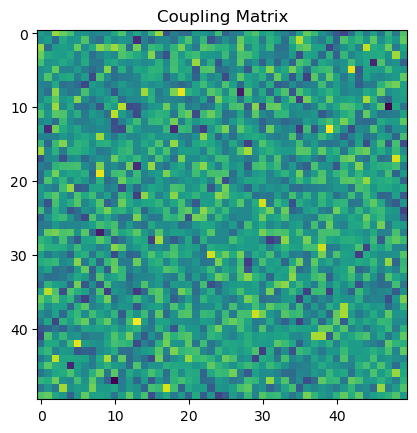

In [34]:
sk = SherringtonKirkpatrickSpinGlass(n=50, random_state=0)
s = sk.random_spins()
print("Energy:", sk.energy(s))

plt.figure()
plt.imshow(sk.J)
plt.title("Coupling Matrix")

# Simulated annealing

**Simulated annealing (SA)** is a stochastic optimization method inspired by the process of slowly cooling a physical system into its ground state. The algorithm steps resemble Monte Carlo sampling, but with a temperature parameter $T$ that is gradually decreased.

1. Start with a random configuration of the system. For the SK model, this is given by an initial spin configuration $\mathbf{s} \in \{-1,+1\}^N$.  

2. At each step, propose a small change. For the SK model, this is given by flipping a single spin, $s_i \to -s_i$ for some $i \in \{1, \ldots, N\}$.

3. If the change **lowers the energy**, accept it.  
4. If the change **raises the energy** by $\Delta E$, accept it with probability $p = e^{-\beta \Delta E}$, just as in Metropolis sampling. As with the Metropolis algorithm, $\beta = 1/k_B T$ sets an inverse energy scale for the system.

5. Gradually reduce the temperature $T$ from a high initial value $T_0$ to a low final value $T_f$. This is the critical difference between SA and the Metropolis algorithm.

The idea behind simulated annealing is to balance **exploration** (avoiding poor local minima and exploring the large set of possible spin configurations) and **exploitation** (refining a candidate solution). The system favors exploration (high temperature) at the beginning of the optimization, and exploitation (low temperature) as it approaches the ground state.


## Implementing simulated annealing

We will implement a `SimulatedAnnealingOptimizer` class that wraps this algorithm. The constructor takes a landscape object with an `energy` method and a `flip_energy_delta` method, which we will use to compute the energy and energy change for a given spin configuration. The optimizer returns the best spin configuration found and the corresponding minimum energy, as well as a dictionary of information about the optimization trajectory.

This algorithm mirrors the physics of annealing: at high temperature spins fluctuate freely, while gradual cooling encourages the system to settle into an approximate ground state.


-51.8118499848442


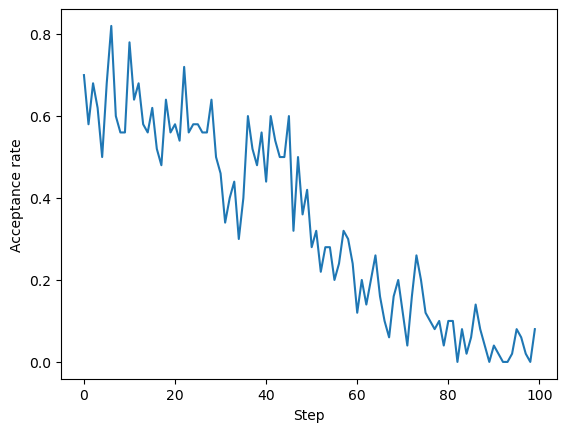

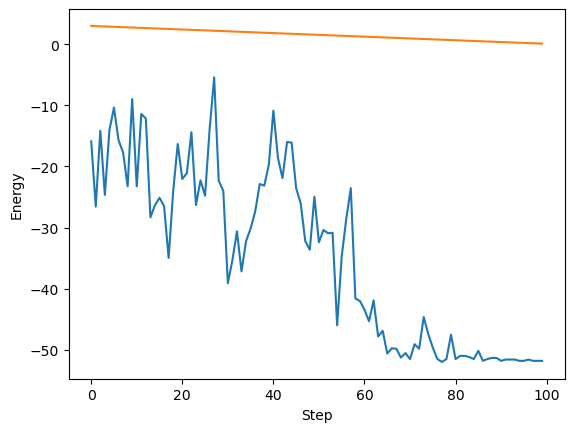

In [ ]:
class SimulatedAnnealing:
    """
    Minimal simulated annealing for an Ising-like system.
    """
    def __init__(self, random_state = None, store_history = True):
        self.random_state = random_state
        np.random.seed(self.random_state)
        self.store_history = store_history
        if self.store_history:
            self.spins_history = []
            self.energies_history = []
            self.acceptance_history = []

    def fit(self, system, temperatures):

        self.spins = system.random_spins()
    
        N = self.spins.size
        for T in np.asarray(temperatures, dtype=float):

            # One sweep per temperature: N random single-spin proposals
            accept_count = 0
            for _ in range(N):
                
                ## Sample a random lattice site with replacement
                i = np.random.randint(0, N)
                dE = system.energy_delta(self.spins, i)

                # Metropolis acceptance
                if dE <= 0.0:
                    accept = True
                else:
                    accept = np.random.random() < np.exp(-dE / T)

                if accept:
                    # Flip in-place; system is expected to be mutable
                    accept_count += 1
                    self.spins[i] = -self.spins[i]
            
            if self.store_history:
                self.spins_history.append(self.spins.copy())
                self.energies_history.append(system.energy(self.spins))
                self.acceptance_history.append(accept_count / N)
        return system.energy(self.spins), self.spins

temperatures = np.linspace(3.0, 0.1, 100)
sa = SimulatedAnnealing()
final_E, final_spins = sa.fit(sk, temperatures)
print(final_E)


plt.figure()
plt.plot(sa.acceptance_history)
plt.xlabel("Step")
plt.ylabel("Acceptance rate")
plt.show()

plt.figure()
plt.plot(sa.energies_history)
plt.plot(temperatures)
plt.xlabel("Step")
plt.ylabel("Energy")
plt.show()


## Annealing schedules and learning rate schedules

Above, we lower the temperature $T$ linearly. This is a common choice, but not the only one. We can also use a **geometric** schedule, where $T$ is multiplied by a factor $r$ at each step:

$$
T_{i+1} = r T_i
$$

We can also use a **logarithmic** schedule, where $T$ is divided by a factor $c$ at each step:

$$
T_{i+1} = T_i / (1 + c \log(i))
$$

We will try implementing these alternate schedules, to see how they perform.


In [57]:
def geometric_schedule(T0, Tf, n_steps):
    if n_steps < 2:
        return np.array([Tf], dtype=float)
    r = (Tf / T0) ** (1.0 / (n_steps - 1))
    return T0 * (r ** np.arange(n_steps))

def linear_schedule(T0, Tf, n_steps):
    return np.linspace(T0, Tf, n_steps, dtype=float)

def log_schedule(T0, c, n_steps):
    ks = np.arange(n_steps)
    return T0 / (1.0 + c * np.log1p(ks))



# temperatures = linear_schedule(3.0, 0.01, 100)
# temperatures = geometric_schedule(3.0, 0.01, 100)
# temperatures = log_schedule(3.0, 0.01, 100)
sa = SimulatedAnnealing()
final_E, final_spins = sa.fit(sk, temperatures)
print(final_E)


-51.988288548883794


# How well did we do? The analytic prediction in the many spin case

We can compare the results of our simulated annealing algorithm to the analytic prediction for the ground state energy of the Sherrington-Kirkpatrick model. In the $N\to\infty$ limit, [various]((https://www.google.com/books/edition/_/DwY8DQAAQBAJ)) analytic [techniques](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.65.046137) based on the replica method estimate a constant energy density of approximately $-0.76321$.

$$
    \mathbb{E}[E_0] = -0.76321 \,N
$$

where $N$ is the number of spins.

https://intlpress.com/site/pub/files/_fulltext/journals/cdm/2014/2014/0001/CDM-2014-2014-0001-a004.pdf

We can compare the results of our simulated annealing algorithm to the analytic prediction.

In [15]:
def analytic_ground_state_energy(n: int) -> float:
    """Returns the approximate ground state energy density in the many spin limit"""
    return -n * 0.76321

analytic_ground_state_energy(sk.n)


-38.160500000000006

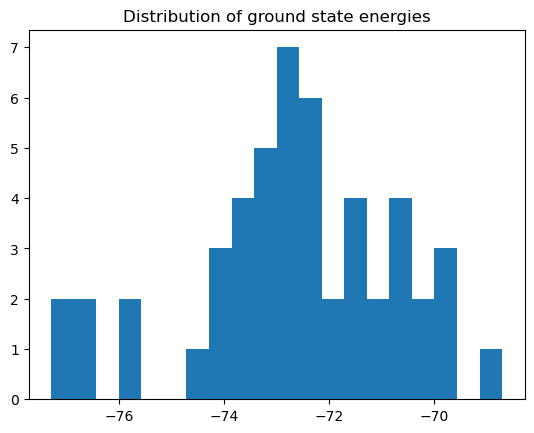

Across replicates, the median ground state energy is -72.76938783655172


In [66]:
all_Es = []
for seed in range(50):
    sk = SherringtonKirkpatrickSpinGlass(n=100, scale="1/sqrt(n)", random_state=seed)
    cfg = SAConfig(steps=300, sweeps_per_step=5, schedule="geometric", T0=3.0, Tf=0.01,
                record_trajectory=True, early_stop_patience=None)
    opt = SimulatedAnnealingOptimizer(sk, cfg)
    s_star, E_star, info = opt.optimize()
    all_Es.append(E_star)

plt.figure()
plt.hist(all_Es, bins=20)
plt.title("Distribution of ground state energies")
plt.show()


print(f"Across replicates, the median ground state energy is {np.median(all_Es)}")


We expect that the gap between the predicted and actual ground state arises due to three effects:

1. The finite size of the system.
2. The finite temperature of the system.
3. Randomness in the couplings.
4. Insufficient optimization.

We can try varying $N$ and see how the gap changes, in order to understand finite size effects. [Prior](https://iopscience.iop.org/article/10.1088/1742-5468/2008/10/P10005) [numerical](https://link.springer.com/article/10.1140/epjb/e2005-00280-6) [studies](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.76.184412) estimate the the gap between the finite and infinite size ground states decreases as $\sim N^{-0.67}$.

However, we can also try improving our optimizer, to see if a better optimizer can close the gap.









# Replica exchange Monte Carlo

In [12]:
from dataclasses import dataclass
from typing import Callable, Dict, Iterable, List, Optional, Sequence, Tuple, Union
import numpy as np
from numpy.random import Generator, PCG64

Array = np.ndarray  # keep consistent with your snippet

# ---------- Optional helpers (reuse your schedule fns if already defined) ----------

def _make_ladder(T_min: float, T_max: float, R: int, schedule: str, log_c: float,
                 custom_schedule_fn: Optional[Callable[[int], Array]]) -> Array:
    if R < 2:
        raise ValueError("Need at least 2 replicas for parallel tempering.")
    if schedule == "custom":
        if custom_schedule_fn is None:
            raise ValueError("custom_schedule_fn must be provided when schedule='custom'.")
        T = np.asarray(custom_schedule_fn(R), dtype=float)
        if T.shape != (R,):
            raise ValueError(f"custom_schedule_fn must return shape ({R},)")
        return np.sort(T)[::-1]  # ensure descending (hot->cold)
    if schedule == "geometric":
        T = geometric_schedule(T_max, T_min, R)  # hot -> cold
    elif schedule == "linear":
        T = linear_schedule(T_max, T_min, R)
    elif schedule == "log":
        # interpret log schedule as applied hot->cold
        ks = np.arange(R)
        T = T_max / (1.0 + log_c * np.log1p(ks))
        # rescale so last equals T_min (nice to control endpoints)
        T = T * (T_min / T[-1])
    else:
        raise ValueError("schedule must be 'geometric', 'linear', 'log', or 'custom'.")
    return T

# ---------- Config ----------

@dataclass
class PTConfig:
    # Ladder / MC parameters
    replicas: int = 24                       # number of temperatures
    steps: int = 400                         # exchange "epochs"
    sweeps_per_step: int = 2                 # local sweeps per replica per step
    schedule: str = "geometric"              # "geometric" | "linear" | "log" | "custom"
    T_max: float = 3.0                       # hottest temperature
    T_min: float = 0.02                      # coldest temperature
    log_c: float = 0.5
    custom_schedule_fn: Optional[Callable[[int], Array]] = None

    # Moves
    use_metropolis: bool = True              # single-spin Metropolis (otherwise heat-bath not provided here)
    quench_every: Optional[int] = None       # e.g., 25 -> run zero-T greedy quench every 25 steps
    use_houdayer: bool = False               # try isoenergetic cluster moves (needs neighbors)
    houdayer_moves_per_step: int = 1
    houdayer_accept: str = "always"          # "always" | "metropolis"
    houdayer_beta_index: str = "avg"         # "min" | "avg" | "max" | int (temperature index)

    # Bookkeeping / control
    rng: Optional[Generator] = None
    record_trajectory: bool = False          # record energies per step per replica
    early_stop_patience: Optional[int] = None  # steps without improvement (on global best)
    swap_scheme: str = "even-odd"            # "even-odd" swaps to satisfy detailed balance

class ParallelTemperingOptimizer:
    """
    Parallel Tempering (Replica-Exchange Monte Carlo) for Ising-like models.

    Model interface expected (same as your SA):
      - n: int
      - energy(s: Iterable[int]) -> float
      - flip_energy_delta(s: Array, i: int) -> float
      - Optional: neighbors(i) -> Iterable[int] OR attribute 'edges' as list of (u,v) for Houdayer.
      - Optional: rng: numpy.random.Generator
    """

    def __init__(self, model, config: Optional[PTConfig] = None):
        self.model = model
        self.config = config or PTConfig()
        self.rng = self.config.rng or getattr(model, "rng", Generator(PCG64()))

        # build ladder hot->cold
        c = self.config
        self.T = _make_ladder(c.T_min, c.T_max, c.replicas, c.schedule, c.log_c, c.custom_schedule_fn)
        self.beta = np.where(self.T > 0.0, 1.0 / self.T, np.inf)

        # try to find graph connectivity for Houdayer
        self._has_neighbors = hasattr(self.model, "neighbors")
        self._edges: Optional[List[Tuple[int,int]]] = None
        if not self._has_neighbors and hasattr(self.model, "edges"):
            self._edges = list(getattr(self.model, "edges"))  # list of (u,v)

    # ------------------------- public API -------------------------

    def optimize(
        self,
        s0: Optional[Union[Iterable[int], Sequence[Array]]] = None,
        callback: Optional[Callable[[int, float, Array], None]] = None,
    ) -> Tuple[Array, float, Dict[str, Array]]:
        """
        Run PT and return (s_best, E_best, info).

        If s0 is an array of length n, it's copied to all replicas.
        If s0 is a sequence of R arrays, they initialize replicas one-to-one.

        info keys:
          - "T": temperature ladder (R,)
          - "swap_attempts": (R-1,) counts per edge
          - "swap_accepts": (R-1,) counts per edge
          - optionally "E_hist": (steps, R) energies per replica
          - "E_best_so_far": (steps,) global best so far
        """
        m, c, rng = self.model, self.config, self.rng
        n, R = m.n, len(self.T)

        # initialize replicas
        if s0 is None:
            states = rng.choice(np.array([-1, 1], dtype=int), size=(R, n))
        else:
            if isinstance(s0, (list, tuple)):
                if len(s0) != R:
                    raise ValueError(f"When providing per-replica s0, expected {R} states.")
                states = np.stack([np.array(si, dtype=int).copy() for si in s0], axis=0)
            else:
                s0_arr = np.array(s0, dtype=int)
                if s0_arr.shape != (n,):
                    raise ValueError(f"s0 must have shape ({n},)")
                states = np.stack([s0_arr.copy() for _ in range(R)], axis=0)

        # energies
        E = np.array([m.energy(states[r]) for r in range(R)], dtype=float)
        best_idx = int(np.argmin(E))
        s_best = states[best_idx].copy()
        E_best = float(E[best_idx])

        # bookkeeping
        swap_attempts = np.zeros(R - 1, dtype=int)
        swap_accepts = np.zeros(R - 1, dtype=int)

        if c.record_trajectory:
            E_hist = np.empty((c.steps, R), dtype=float)
            Ebs = np.empty(c.steps, dtype=float)

        no_imp = 0
        for step in range(c.steps):
            # local updates
            for r in range(R):
                self._local_sweeps(states[r], E, r, c.sweeps_per_step)

            # (optional) Houdayer / isoenergetic cluster moves
            if c.use_houdayer:
                for _ in range(c.houdayer_moves_per_step):
                    self._try_houdayer(states, E)

            # swap stage (even-odd alternation)
            if c.swap_scheme == "even-odd":
                start = step % 2  # 0: swap (0,1),(2,3),... ; 1: (1,2),(3,4),...
                for r in range(start, R - 1, 2):
                    self._attempt_swap(states, E, r, r + 1, swap_attempts, swap_accepts)

            # zero-T greedy quench (optional, very effective)
            if c.quench_every is not None and (step + 1) % c.quench_every == 0:
                # quench only a subset to save time; include cold replicas
                self._greedy_quench(states[0], E, 0)           # coldest
                self._greedy_quench(states[min(1, R-1)], E, min(1, R-1))

            # track best
            r_min = int(np.argmin(E))
            if E[r_min] < E_best:
                E_best = float(E[r_min])
                s_best = states[r_min].copy()
                no_imp = 0
            else:
                no_imp += 1

            if c.record_trajectory:
                E_hist[step] = E
                Ebs[step] = E_best

            if callback is not None:
                # keep signature similar to SA: (k, E, s) -> here E_best, s_best
                callback(step, E_best, s_best)

            if c.early_stop_patience is not None and no_imp >= c.early_stop_patience:
                if c.record_trajectory:
                    E_hist = E_hist[: step + 1]
                    Ebs = Ebs[: step + 1]
                break

        info: Dict[str, Array] = {
            "T": self.T.copy(),
            "swap_attempts": swap_attempts,
            "swap_accepts": swap_accepts,
        }
        if c.record_trajectory:
            info["E_hist"] = E_hist
            info["E_best_so_far"] = Ebs
        return s_best, E_best, info

    # ------------------------- kernels -------------------------

    def _local_sweeps(self, s: Array, E: Array, r_idx: int, sweeps: int) -> None:
        """Metropolis single-spin sweeps at temperature index r_idx."""
        m, rng = self.model, self.rng
        beta = self.beta[r_idx]
        n = m.n
        for _ in range(sweeps * n):
            i = rng.integers(0, n)
            dE = m.flip_energy_delta(s, i)
            # Metropolis
            if dE <= 0.0 or (beta < np.inf and rng.random() < np.exp(-beta * dE)):
                s[i] = -s[i]
                E[r_idx] += dE

    def _attempt_swap(
        self,
        states: Array,
        E: Array,
        r: int,
        rp: int,
        swap_attempts: Array,
        swap_accepts: Array,
    ) -> None:
        """Neighbor swap between replicas r (hotter) and rp (colder)."""
        beta_r, beta_rp = self.beta[r], self.beta[rp]
        d = (beta_r - beta_rp) * (E[rp] - E[r])
        acc = 1.0 if d <= 0.0 else np.exp(-d)
        swap_attempts[r] += 1
        if self.rng.random() < acc:
            # swap configurations and energies
            states[[r, rp]] = states[[rp, r]]
            E[r], E[rp] = E[rp], E[r]
            swap_accepts[r] += 1

    def _greedy_quench(self, s: Array, E: Array, r_idx: int) -> None:
        """Zero-temperature greedy descent on replica r_idx."""
        m, rng = self.model, self.rng
        n = m.n
        improved = True
        while improved:
            improved = False
            # random order reduces bias
            for i in rng.permutation(n):
                dE = m.flip_energy_delta(s, i)
                if dE < 0.0:
                    s[i] = -s[i]
                    E[r_idx] += dE
                    improved = True

    # ---------- Houdayer / isoenergetic cluster move (optional) ----------

    def _try_houdayer(self, states: Array, E: Array) -> None:
        """
        Perform one Houdayer-like cluster move on a random pair of replicas.
        Requires either model.neighbors(i) or model.edges list[(u,v)].
        """
        if not self._has_neighbors and self._edges is None:
            return  # no graph information available

        rng = self.rng
        R = len(self.T)
        # pick two replicas reasonably close in T to maintain acceptance
        r = rng.integers(0, R - 1)
        rp = r + 1 if rng.random() < 0.5 and r + 1 < R else max(0, r - 1)

        a = states[r].copy()
        b = states[rp].copy()

        # build disagreement mask
        disagree = (a != b)
        if not np.any(disagree):
            return

        # pick random seed in the disagreement set
        idxs = np.flatnonzero(disagree)
        seed = int(idxs[rng.integers(0, len(idxs))])

        # grow connected component within the disagreement subgraph
        cluster = self._disagreement_cluster(disagree, seed)

        # propose flipping cluster spins in both replicas
        a_new = a.copy()
        b_new = b.copy()
        a_new[cluster] *= -1
        b_new[cluster] *= -1

        if self.config.houdayer_accept == "always":
            states[r] = a_new
            states[rp] = b_new
            # energies unchanged for ±J, h=0; in general recompute to be safe
            E[r] = self.model.energy(states[r])
            E[rp] = self.model.energy(states[rp])
        else:
            # Metropolis on total ΔE using an effective β
            beta_eff = self._select_beta_for_pair(r, rp)
            Ea0, Eb0 = E[r], E[rp]
            Ea1 = self.model.energy(a_new)
            Eb1 = self.model.energy(b_new)
            dE = (Ea1 + Eb1) - (Ea0 + Eb0)
            if dE <= 0.0 or self.rng.random() < np.exp(-beta_eff * dE):
                states[r] = a_new
                states[rp] = b_new
                E[r] = Ea1
                E[rp] = Eb1

    def _disagreement_cluster(self, disagree_mask: Array, seed: int) -> Array:
        """Return boolean mask of connected component within the disagreement set."""
        n = disagree_mask.shape[0]
        in_cluster = np.zeros(n, dtype=bool)
        if self._has_neighbors:
            # BFS using neighbors(i)
            queue = [seed]
            in_cluster[seed] = True
            while queue:
                v = queue.pop()
                for u in self.model.neighbors(v):
                    if disagree_mask[u] and not in_cluster[u]:
                        in_cluster[u] = True
                        queue.append(u)
        else:
            # Use pre-supplied edges list (u,v)
            queue = [seed]
            in_cluster[seed] = True
            # build adjacency lazily for mask-relevant edges
            while queue:
                v = queue.pop()
                for (u, w) in self._edges:
                    if u == v and disagree_mask[w] and not in_cluster[w]:
                        in_cluster[w] = True
                        queue.append(w)
                    elif w == v and disagree_mask[u] and not in_cluster[u]:
                        in_cluster[u] = True
                        queue.append(u)
        return in_cluster

    def _select_beta_for_pair(self, r: int, rp: int) -> float:
        mode = self.config.houdayer_beta_index
        if isinstance(mode, int):
            idx = int(np.clip(mode, 0, len(self.beta) - 1))
            return float(self.beta[idx])
        if mode == "min":
            return float(min(self.beta[r], self.beta[rp]))
        if mode == "max":
            return float(max(self.beta[r], self.beta[rp]))
        # "avg"
        return 0.5 * float(self.beta[r] + self.beta[rp])




PT best energy: -68.91054567987499
Median swap acceptance: 0.724


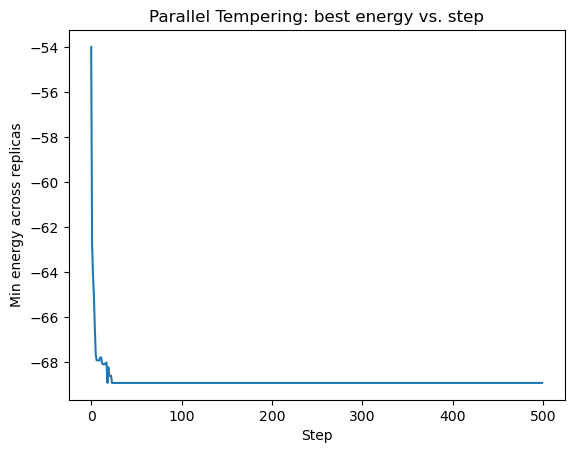

In [23]:
cfg_pt = PTConfig(
    replicas=24,
    steps=500,
    sweeps_per_step=2,
    schedule="geometric",
    T_max=3.0, T_min=0.02,
    record_trajectory=True,
    use_houdayer=True,             # requires model.neighbors or model.edges
    houdayer_accept="metropolis",  # safer if fields are present
    quench_every=50,               # occasional zero-T polish
)
pt = ParallelTemperingOptimizer(sk, cfg_pt)  # 'sk' = your Ising model (same one used for SA)
s_star, E_star, info = pt.optimize()
print("PT best energy:", E_star)
acc_rate = info["swap_accepts"] / np.maximum(1, info["swap_attempts"])
print("Median swap acceptance:", float(np.median(acc_rate)))

if "E_hist" in info:
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(np.min(info["E_hist"], axis=1))
    plt.xlabel("Step"); plt.ylabel("Min energy across replicas")
    plt.title("Parallel Tempering: best energy vs. step")
    plt.show()

## Approaching the replica limit

In [ ]:
for nval in range(10, 100, 10):
    sk = SherringtonKirkpatrickSpinGlass(n=nval, scale="1/sqrt(n)", random_state=1)

    pt = ParallelTemperingOptimizer(sk, cfg_pt)  # 'sk' = your Ising model (same one used for SA)
    s_star, E_star_pt, info = pt.optimize()

    sa = SimulatedAnnealingOptimizer(sk, cfg)
    s_star, E_star_sa, info = sa.optimize()
    
    gs = analytic_ground_state_energy(sk.n)
    print(f"n={nval}, PT E={E_star_pt:.4f}, SA E={E_star_sa:.4f}, GS E={gs:.4f}")


n=10, PT E=-5.0194, SA E=-5.0194, GS E=-7.6321
n=20, PT E=-12.2016, SA E=-12.2016, GS E=-15.2642
n=30, PT E=-17.7225, SA E=-17.7225, GS E=-22.8963
n=40, PT E=-26.7006, SA E=-26.7006, GS E=-30.5284
n=50, PT E=-33.9008, SA E=-33.3665, GS E=-38.1605
n=60, PT E=-40.5005, SA E=-40.5005, GS E=-45.7926
n=70, PT E=-49.5846, SA E=-49.5846, GS E=-53.4247
n=80, PT E=-58.9475, SA E=-58.9475, GS E=-61.0568
n=90, PT E=-68.9105, SA E=-68.9105, GS E=-68.6889


In [17]:
sk.n

50

In [5]:
import numpy as np

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, Image

%matplotlib inline


### Two-spin Online Convex Optimization via convexification (correlation control)

Our optimization variables are discrete, and correspond to the spins of a 2-spin Ising model.

$$
\begin{align*}
    \mathcal{L} & = - \sum_{i=1}^N \sum_{j=1}^N J_{ij} s_i s_j \\
    \mathcal{L} & = - J_{12} s_1 s_2
\end{align*}
$$

We can globally minimize the loss simply by *combinatorial optimization*. We try all $2 \times 2 = 4$ possible values of the spins, and pick the one that minimizes the loss. However, while this is tractable for the two spin case, it is expensive (problem size scales in $N$ and likely non-convex. What if we instead wanted to pose this as an online learning problem suitable for iterative optimization? 

We need to define a surrogate loss that is convex and differentiable, and that we can optimize. For this case, we can use correlation:
$$
  \hat{\mathcal{L}} = s_1 s_2
$$

### Establishing bounds on the surrogate loss

At each round indexed by $t$, we propose a spin configuration $s_{1t}$, $s_{2t}$ we compute a surrogate loss $\hat{\mathcal{L}}$. We want to establish bounds on the surrogate loss, assuming that we made the worst possible choice for $s_{1t}$, $s_{2t}$.

$$
\begin{align*}
  \hat{\mathcal{L}} & = s_{1t} s_{2t} \\
  \hat{\mathcal{L}} & = s_{1t} s_{2t}
\end{align*}
$$


In [1]:
import numpy as np

def sample_spins_with_correlation(c, rng):
    """
    Given target correlation c in [-1,1], sample (s1,s2) in {±1}^2 with E[s1*s2]=c.
    """
    assert -1.0 <= c <= 1.0
    s1 = rng.choice([-1, 1])
    if rng.random() < (1 + c) / 2:
        s2 = s1
    else:
        s2 = -s1
    return s1, s2

def run_2spin_ogd(T=200, eta=None, j_seq=None, adversary="adaptive", seed=0):
    """
    Online gradient descent on the convex surrogate c_t ∈ [-1,1] for two spins.
    Loss per round: ℓ_t = - j_t * (s1_t*s2_t).
    Update on expected loss: c_{t+1} = Proj_{[-1,1]}(c_t + η * j_t).

    adversary:
      - "adaptive": chooses j_t = -sign(c_t) (worst for the current c_t), with tie broken uniformly
      - "given":    uses provided j_seq (length T), values in [-1,1]
      - "random":   j_t ~ Unif({-1, +1})
    """
    rng = np.random.default_rng(seed)
    if eta is None:
        eta = 2.0 / np.sqrt(T)  # OGD step ~ D/(G*sqrt(T)) with D=2, G≤1
    c = 0.0  # start at 0 correlation
    c_hist = []
    j_hist = []
    loss_realized = []
    loss_expected = []

    for t in range(T):
        # Adversary picks j_t after seeing c_t
        if adversary == "adaptive":
            s = np.sign(c)
            if s == 0:
                j_t = rng.choice([-1.0, 1.0])
            else:
                j_t = -float(s)  # linear loss -j*c is maximized by j = -sign(c)
        elif adversary == "given":
            if j_seq is None or len(j_seq) != T:
                raise ValueError("Provide j_seq of length T for adversary='given'.")
            j_t = float(j_seq[t])
        elif adversary == "random":
            j_t = rng.choice([-1.0, 1.0])
        else:
            raise ValueError("adversary must be in {'adaptive','given','random'}")
        j_hist.append(j_t)

        # Play discrete spins realizing correlation c
        s1, s2 = sample_spins_with_correlation(c, rng)
        prod = s1 * s2

        # Losses
        loss_t_real = - j_t * prod
        loss_t_exp  = - j_t * c
        loss_realized.append(loss_t_real)
        loss_expected.append(loss_t_exp)

        # OGD update on the convex surrogate (expected loss)
        c = np.clip(c + eta * j_t, -1.0, 1.0)
        c_hist.append(c)

    # Best fixed comparator over c in {±1} (equivalently, best fixed spin product)
    S = float(np.sum(j_hist))
    c_star = 1.0 if S < 0 else -1.0 if S > 0 else 1.0  # minimizes -S*c
    comp_expected = - c_star * S

    out = {
        "c_hist": np.array(c_hist),
        "j_hist": np.array(j_hist),
        "loss_realized": np.array(loss_realized),
        "loss_expected": np.array(loss_expected),
        "cum_loss_realized": float(np.sum(loss_realized)),
        "cum_loss_expected": float(np.sum(loss_expected)),
        "cum_loss_comp_expected": float(comp_expected),
        "regret_expected": float(np.sum(loss_expected) - comp_expected),
        "params": {"T": T, "eta": eta, "adversary": adversary, "seed": seed}
    }
    return out


res2 = run_2spin_ogd(T=200, adversary="adaptive", seed=0)
print("2-spin: cum expected loss =", res2["cum_loss_expected"],
        " comparator exp. loss =", res2["cum_loss_comp_expected"],
        " regret_exp =", res2["regret_expected"])


2-spin: cum expected loss = 14.142135623730947  comparator exp. loss = -0.0  regret_exp = 14.142135623730947


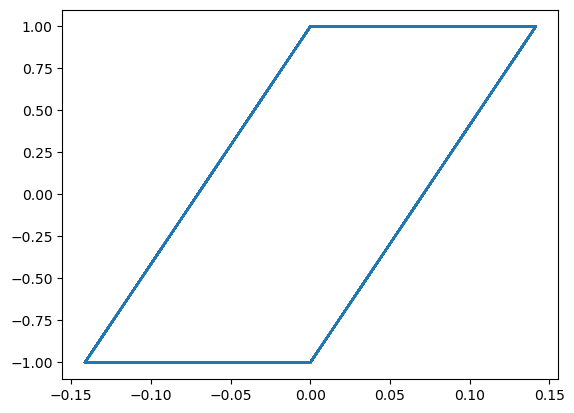

In [8]:
plt.plot(res2["c_hist"], res2["j_hist"])

In [9]:



# ============================================================
# 2) n-spin Ising with adversarial J_t, convex relaxation
#    (elliptope surrogate + Gaussian sign rounding)
#    NOTE: uses an approximate projection to the elliptope.
# ============================================================

def project_psd_with_unit_diag(C, eps=1e-10):
    """
    Approximate projection onto {C ⪰ 0, diag(C)=1}.
    Steps: symmetrize → set diag to 1 → PSD projection (clip neg eigvals) → reset diag to 1.
    This is not the exact elliptope projection (which is an SDP), but works well in practice.
    """
    C = 0.5 * (C + C.T)
    np.fill_diagonal(C, 1.0)
    # PSD projection
    w, V = np.linalg.eigh(C)
    w_clipped = np.clip(w, a_min=0.0, a_max=None)
    C_psd = (V * w_clipped) @ V.T
    C_psd = 0.5 * (C_psd + C_psd.T)
    # Enforce unit diagonal again (light renormalization)
    d = np.sqrt(np.maximum(np.diag(C_psd), eps))
    D_inv = np.diag(1.0 / d)
    C_norm = D_inv @ C_psd @ D_inv
    C_norm = 0.5 * (C_norm + C_norm.T)
    np.fill_diagonal(C_norm, 1.0)
    return C_norm

def gaussian_sign_rounding(C, rng):
    """
    Sample s ∈ {±1}^n via Gaussian sign rounding with covariance C.
    """
    n = C.shape[0]
    # Ensure strictly PD covariance for sampling
    jitter = 1e-8
    G = rng.multivariate_normal(mean=np.zeros(n), cov=C + jitter * np.eye(n))
    s = np.sign(G)
    s[s == 0] = 1
    return s.astype(int)

def adversary_against_spins(s):
    """
    Worst-case (entrywise-bounded) J_t for current spin s:
      J_ij = - s_i s_j for i ≠ j,  J_ii = 0.
    This maximizes loss -s^T J s subject to |J_ij| ≤ 1 and zero diagonal.
    """
    n = len(s)
    J = -np.outer(s, s)
    np.fill_diagonal(J, 0.0)
    return J

def run_nspin_online_relaxation(n=20, T=200, eta=None, J_seq=None, adversary="adaptive", seed=1):
    """
    Online linear optimization over the elliptope surrogate C_t, with Gaussian sign rounding to play spins.
    Loss per round: ℓ_t(s_t) = - s_t^T J_t s_t. Surrogate loss: L_t(C_t) = -⟨J_t, C_t⟩.

    Update: C_{t+1} ≈ Proj_{elliptope}( C_t + η * J_t )
    (gradient of L_t wrt C is -J_t; gradient DEScent step is C - η*(-J_t) = C + η J_t)

    adversary:
      - "adaptive": picks J_t = adversary_against_spins(s_t)
      - "given":    uses provided list of J_t (len T), symmetric with zero diagonal
      - "random":   i.i.d. J_t with entries in {-1, +1} off-diagonal and 0 on diagonal
    """
    rng = np.random.default_rng(seed)
    if eta is None:
        eta = 1.0 / np.sqrt(T)  # heuristic O(1/sqrt(T)) step
    C = np.eye(n)
    C_hist = []
    loss_realized = []
    loss_surrogate = []
    Js = []

    for t in range(T):
        # Play spins via rounding of current correlation C
        s = gaussian_sign_rounding(C, rng)

        # Adversary chooses J_t
        if adversary == "adaptive":
            J_t = adversary_against_spins(s)
        elif adversary == "given":
            if J_seq is None or len(J_seq) != T:
                raise ValueError("Provide J_seq (len T, symmetric, zero diagonal) for adversary='given'.")
            J_t = 0.5 * (J_seq[t] + J_seq[t].T)
            np.fill_diagonal(J_t, 0.0)
        elif adversary == "random":
            J_t = rng.choice([-1.0, 1.0], size=(n, n))
            J_t = 0.5 * (J_t + J_t.T)
            np.fill_diagonal(J_t, 0.0)
        else:
            raise ValueError("adversary must be in {'adaptive','given','random'}")
        Js.append(J_t)

        # Realized discrete loss
        loss_t = - float(s.T @ J_t @ s)
        loss_realized.append(loss_t)

        # Surrogate (expected) loss under C_t: -⟨J_t, C_t⟩
        loss_sur = - float(np.sum(J_t * C))
        loss_surrogate.append(loss_sur)

        # Online update on the surrogate
        C = C + eta * J_t
        C = project_psd_with_unit_diag(C)  # approximate projection
        C_hist.append(C.copy())

    # Comparator (best fixed spin in hindsight) for reporting:
    # NP-hard to compute exactly; we report the surrogate comparator instead.
    comp_surrogate = -float(np.sum(np.sum(Js, axis=0) * np.eye(n)))  # = 0 since diag=0; kept for clarity
    # Better: best fixed C in the surrogate is not trivial; we omit exact value and report totals.

    out = {
        "C_hist": C_hist,
        "loss_realized": np.array(loss_realized),
        "loss_surrogate": np.array(loss_surrogate),
        "cum_loss_realized": float(np.sum(loss_realized)),
        "cum_loss_surrogate": float(np.sum(loss_surrogate)),
        "params": {"n": n, "T": T, "eta": eta, "adversary": adversary, "seed": seed}
    }
    return out




# Example 2: n-spin relaxation with adaptive adversary
resN = run_nspin_online_relaxation(n=20, T=200, adversary="adaptive", seed=1)
print("n-spin: cum realized loss =", resN["cum_loss_realized"],
        " cum surrogate loss =", resN["cum_loss_surrogate"])

n-spin: cum realized loss = 76000.0  cum surrogate loss = 886.0047399131901


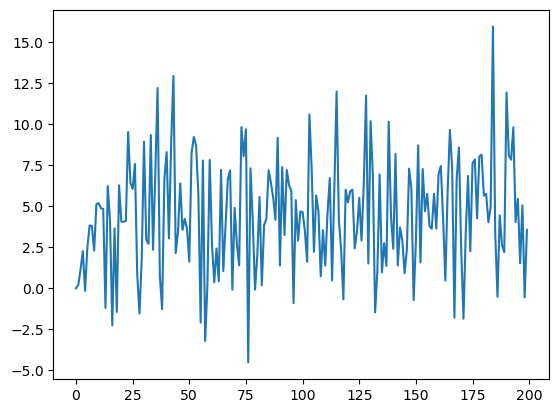

In [12]:
plt.plot(resN["loss_surrogate"])